### Libraries

In [1]:
import os, sys
sys.path.insert(0,"/projects/QUIJOTE/Neerav/UNIVERSAL")
import pandas as pd
import numpy as np
import MAS_library as MASL
import Pk_library as PKL
import matplotlib.pyplot as plt
import sys,os,h5py
import readsnap, readgadget
import time
import threading
from mpl_toolkits.axes_grid1 import make_axes_locatable
from my_routines import get_runtime
from pylab import *
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.colors import LogNorm

### Params 

In [2]:
do_RSD        = False
axis          = 0 
threads       = 32
x_min, x_max  = 0.0, 1000
y_min, y_max  = 0.0, 1000
z_min, z_max  = 0.0, 1000
boxsize       = 1000
ptypes        = [1]
grid          = 512
dpi           = 300
poslag        = np.load("/projects/QUIJOTE/Neerav/DATA/project_1_results/poslag.npy") #----EDIT
#rootdir       = "/projects/QUIJOTE/Neerav"
rootdir      = "/scratch/gpfs/QUIJOTE"
pkMAS         = 5*['CIC'] #--------------EDIT
bispectrumMAS = ['CIC']
deltaMAS      = 'CIC'
splits        = 20
theta         = np.linspace(0, np.pi, splits)
k1, k2        = 0.15, 0.25
start, stop   = 130, 139 #------------------------------EDIT

CHOICE = 2 #----power spectra = 1, bispectra = 2
print_stats = 0
print_runtime = 1

### Functions 

In [3]:
def get_overdensity(posf, MAS=deltaMAS, projection='3D', kind='overdensity'):
    pos         = posf[:].astype(np.float32)
    pos         = pos.reshape(3,512**3).transpose((1,0))
    assert pos.shape==(512**3,3), "Shape mismatch! Check input posf!"
    indexes     = np.where((pos[:,0]>=x_min) & (pos[:,0]<=x_max) & (pos[:,1]>=y_min) & (pos[:,1]<=y_max) & (pos[:,2]>=z_min) & (pos[:,2]<=z_max))[0]
    pos         = pos[indexes]
    pos[:,0]   -= x_min
    pos[:,1]   -= y_min
    pos[:,2]   -= z_min
    
    if projection=='2D':
        pos_2D = pos[:,0:2]
        overdensity = np.zeros((grid,grid), dtype=np.float32)
        MASL.MA(pos_2D, overdensity, boxsize, MAS)
    else:
        overdensity = np.zeros((grid,grid,grid), dtype=np.float32)
        MASL.MA(pos, overdensity, boxsize, MAS)
    
    #print('{} should be equal to {}'.format(len(pos),np.sum(overdensity)))
    overdensity /= np.mean(overdensity)
    if kind=='density_contrast':
        return overdensity
    elif kind=="overdensity":
        overdensity -= 1.0
        return overdensity

def get_stats(x):
    return x.shape, x.min(), x.max(), x.mean(), x.std()

def get_avg(x):
    return np.mean(x, axis=0)

def get_final_pos(lagrangian_pos, *path_displacement):
    disp = np.load(os.path.join(*path_displacement))
    posf = disp + lagrangian_pos
    posf[posf <= 0      ] += boxsize
    posf[posf >= boxsize] -= boxsize
    assert 0.0 <= np.all(posf) <= boxsize, 'Check predictions'
    return posf

def get_bispectrums(overdensity, MAS=bispectrumMAS, reduced=False):
    BBk = PKL.Bk(overdensity, boxsize, k1, k2, theta, MAS, threads)
    bk = BBk.B
    k  = BBk.k
    if reduced:
        qk = BBk.Q
        return bk, qk
    return bk

### Extract final positions from displacements

In [ ]:
# path_to_save='/scratch/gpfs/QUIJOTE/FINAL/DATA'
# if not os.path.exists(path_to_save):
#     os.makedirs(path_to_save)

# for real in range(start,stop+1):    
#     posf_quij        = get_final_pos(poslag, rootdir, "datasets", "temp_data/LH_quijdisp_%d.npy"%real)
#     posf_cola        = get_final_pos(poslag, rootdir, "datasets", "temp_data/LH_coladisp_%d.npy"%real)
#     posf_za          = get_final_pos(poslag, rootdir, "datasets", "temp_data/LH_zadisp_%d.npy"%real)
#     posf_cola2quij   = get_final_pos(poslag, rootdir2, "FINAL", "cola2quij"  , "LH_quijdisp_%d_out.npy"%real)
#     posf_za2quij     = get_final_pos(poslag, rootdir2, "FINAL", "za2quij"    , "LH_quijdisp_%d_out.npy"%real)
    
#     np.save(os.path.join(path_to_save, "LH_posf_quij_%d.npy"%real), posf_quij)
#     np.save(os.path.join(path_to_save, "LH_posf_cola_%d.npy"%real), posf_cola)
#     np.save(os.path.join(path_to_save, "LH_posf_za_%d.npy"%real  ), posf_za)
#     np.save(os.path.join(path_to_save, "LH_posf_cola2quij_%d.npy"%real), posf_cola2quij)
#     np.save(os.path.join(path_to_save, "LH_posf_za2quij_%d.npy"%real  ), posf_za2quij)

#     print("Saved data for realization %d."%real)
    
# print("Done!")

In [7]:
#---path to save graphs
path_to_save='/scratch/gpfs/QUIJOTE/FINAL/test_results/graphs/after_edit_1'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

### Extracting cosmological statistics 

In [ ]:
if CHOICE==1:
    K = []
    PK_cola2quij, PK_za2quij, PK_quij, PK_cola, PK_za = [],[],[],[],[]
    R_cola2quij_x_quij, R_za2quij_x_quij, R_cola_x_quij, R_za_x_quij = [],[],[],[]

elif CHOICE==2:
    BK_cola2quij, BK_za2quij, BK_quij, BK_cola, BK_za = [], [], [], [], []
    QK_cola2quij, QK_za2quij, QK_quij, QK_cola, QK_za = [], [], [], [], []

if print_runtime: tA = time.time()

for real in range(start,stop+1):
    if print_runtime: t1 = time.time()
    #print("="*50)
    #print("Processing realization %d"%real)
    #print("="*50)
    
    posf_quij = np.load("/scratch/gpfs/QUIJOTE/FINAL/data/posf_quij_%d.npy"%real)
    posf_cola = np.load("/scratch/gpfs/QUIJOTE/FINAL/data/posf_cola_%d.npy"%real)
    posf_za   = np.load("/scratch/gpfs/QUIJOTE/FINAL/data/posf_za_%d.npy"  %real)
    posf_cola2quij = np.load("/scratch/gpfs/QUIJOTE/FINAL/data/posf_cola2quij_%d.npy"%real)
    posf_za2quij   = np.load("/scratch/gpfs/QUIJOTE/FINAL/data/posf_za2quij_%d.npy"  %real)
    
    #print("Calculating overdensities...")
    delta_quij      = get_overdensity(posf_quij)
    delta_cola      = get_overdensity(posf_cola)
    delta_za        = get_overdensity(posf_za)
    delta_cola2quij = get_overdensity(posf_cola2quij)
    delta_za2quij   = get_overdensity(posf_za2quij)
        
    if CHOICE==1:
        #print('Calculating power spectrum...')
        crossPK = PKL.XPk([delta_quij, delta_cola, delta_za, delta_cola2quij, delta_za2quij],
                           boxsize, axis, pkMAS, threads);

        k = crossPK.k3D
        pk_quij          = crossPK.Pk[:,0,0]
        pk_cola          = crossPK.Pk[:,0,1]
        pk_za            = crossPK.Pk[:,0,2]
        pk_cola2quij     = crossPK.Pk[:,0,3]
        pk_za2quij       = crossPK.Pk[:,0,4]

        xpk_cola_quij        = crossPK.XPk[:,0,0]
        xpk_za_quij          = crossPK.XPk[:,0,1]
        xpk_cola2quij_quij   = crossPK.XPk[:,0,2]
        xpk_za2quij_quij     = crossPK.XPk[:,0,3]

        #print('Calculating cross-correlations...')
        r_cola_x_quij        = xpk_cola_quij        / np.sqrt(pk_cola        * pk_quij)
        r_za_x_quij          = xpk_za_quij          / np.sqrt(pk_za          * pk_quij)
        r_cola2quij_x_quij   = xpk_cola2quij_quij   / np.sqrt(pk_cola2quij   * pk_quij)
        r_za2quij_x_quij     = xpk_za2quij_quij     / np.sqrt(pk_za2quij     * pk_quij)

        #print('Saving data...')
        K.append(k)
        PK_quij.append(pk_quij)
        PK_cola.append(pk_cola)
        PK_za.append(pk_za)
        PK_cola2quij.append(pk_cola2quij)
        PK_za2quij.append(pk_za2quij)

        R_cola_x_quij.append(r_cola_x_quij)
        R_za_x_quij.append(r_za_x_quij)
        R_cola2quij_x_quij.append(r_cola2quij_x_quij)
        R_za2quij_x_quij.append(r_za2quij_x_quij)
        
        
    elif CHOICE==2:
        print('Calculating bispectrum and reduced bispectrum...')
        bk_quij = get_bispectrums(delta_quij, reduced=0)
        bk_cola = get_bispectrums(delta_cola, reduced=0)
        bk_za   = get_bispectrums(delta_za  , reduced=0)
        bk_cola2quij = get_bispectrums(delta_cola2quij, reduced=0)
        bk_za2quij   = get_bispectrums(delta_za2quij  , reduced=0)
        
        print("Saving data...")
        BK_quij.append(bk_quij)
        BK_cola.append(bk_cola)
        BK_za.append(bk_za)
        BK_cola2quij.append(bk_cola2quij)
        BK_za2quij.append(bk_za2quij)

#         QK_quij.append(qk_quij)
#         QK_cola.append(qk_cola)
#         BK_za.append(bk_za)
#         QK_cola2quij.append(qk_cola2quij)
#         QK_za2quij.append(qk_za2quij)
        
    if print_stats:
        print("quij              :", get_stats(posf_quij))
        print("cola              :", get_stats(posf_cola))
        print("za                :", get_stats(posf_za))
        print("preds cola2quij   :", get_stats(posf_cola2quij))
        print("preds za2quij     :", get_stats(posf_za2quij))
        
    if print_runtime:
        print("Realization runtime:", get_runtime(time.time()-t1),'\n')
        
if print_runtime:
    print("#"*200)
    print("Total time to analyze %d realizations: "%(stop-start+1), get_runtime(time.time()-tA))
    print("#"*200)

# Averaging 

In [ ]:
CHOICE = 1
if CHOICE==1:
    avg_k            = get_avg(K)
    avg_pk_quij      = get_avg(PK_quij)
    avg_pk_cola      = get_avg(PK_cola)
    avg_pk_za        = get_avg(PK_za)
    avg_pk_cola2quij = get_avg(PK_cola2quij)
    avg_pk_za2quij   = get_avg(PK_za2quij)

    avg_r_cola_x_quij      = get_avg(R_cola_x_quij)
    avg_r_za_x_quij        = get_avg(R_za_x_quij)
    avg_r_cola2quij_x_quij = get_avg(R_cola2quij_x_quij)
    avg_r_za2quij_x_quij   = get_avg(R_za2quij_x_quij)
    
CHOICE = 2
if CHOICE==2:
    avg_bk_quij        = get_avg(BK_quij)
    avg_bk_cola        = get_avg(BK_cola)
    avg_bk_za          = get_avg(BK_za)
    avg_bk_cola2quij   = get_avg(BK_cola2quij)
    avg_bk_za2quij     = get_avg(BK_za2quij)

# Saving to file

In [ ]:
def save_array(name,listy):
    arr = np.array(listy)
    np.save(name, arr)

save_array("test_pk_quij.npy"     , avg_pk_quij)
save_array("test_pk_cola.npy"     , avg_pk_cola)
save_array("test_pk_za.npy"       , avg_pk_za)
save_array("test_pk_cola2quij.npy", avg_pk_cola2quij)
save_array("test_pk_za2quij.npy"  , avg_pk_za2quij)

save_array("test_r_quij_cola.npy"     , avg_r_cola_x_quij)
save_array("test_r_quij_za.npy"       , avg_r_za_x_quij)
save_array("test_r_quij_cola2quij.npy", avg_r_cola2quij_x_quij)
save_array("test_r_quij_za2quij.npy"  , avg_r_za2quij_x_quij)

save_array("test_bk_quij.npy"     , avg_bk_quij)
save_array("test_bk_cola.npy"     , avg_bk_cola)
save_array("test_bk_za.npy"       , avg_bk_za)
save_array("test_bk_cola2quij.npy", avg_bk_cola2quij)
save_array("test_bk_za2quij.npy"  , avg_bk_za2quij)

# Read results 

In [4]:
avg_k            = get_avg(np.load("test_results/K.npy"))
avg_pk_quij      = np.load("test_results/test_Pk_quij.npy")
avg_pk_cola      = np.load("test_results/test_Pk_cola.npy")
avg_pk_za        = np.load("test_results/test_Pk_za.npy")
avg_pk_cola2quij = np.load("test_results/test_Pk_cola2quij.npy")
avg_pk_za2quij   = np.load("test_results/test_Pk_za2quij.npy")

avg_r_cola_x_quij      = np.load("test_results/test_r_quij_cola.npy")
avg_r_za_x_quij        = np.load("test_results/test_r_quij_za.npy")
avg_r_cola2quij_x_quij = np.load("test_results/test_r_quij_cola2quij.npy")
avg_r_za2quij_x_quij   = np.load("test_results/test_r_quij_za2quij.npy")

avg_bk_quij = np.load("test_results/test_bk_quij.npy")
avg_bk_cola = np.load("test_results/test_bk_cola.npy")
avg_bk_za   = np.load("test_results/test_bk_za.npy")
avg_bk_cola2quij = np.load("test_results/test_bk_cola2quij.npy")
avg_bk_za2quij   = np.load("test_results/test_bk_za2quij.npy")

# $P(k), T(k), B(k)\text{ and ratio of }B(k)$ 

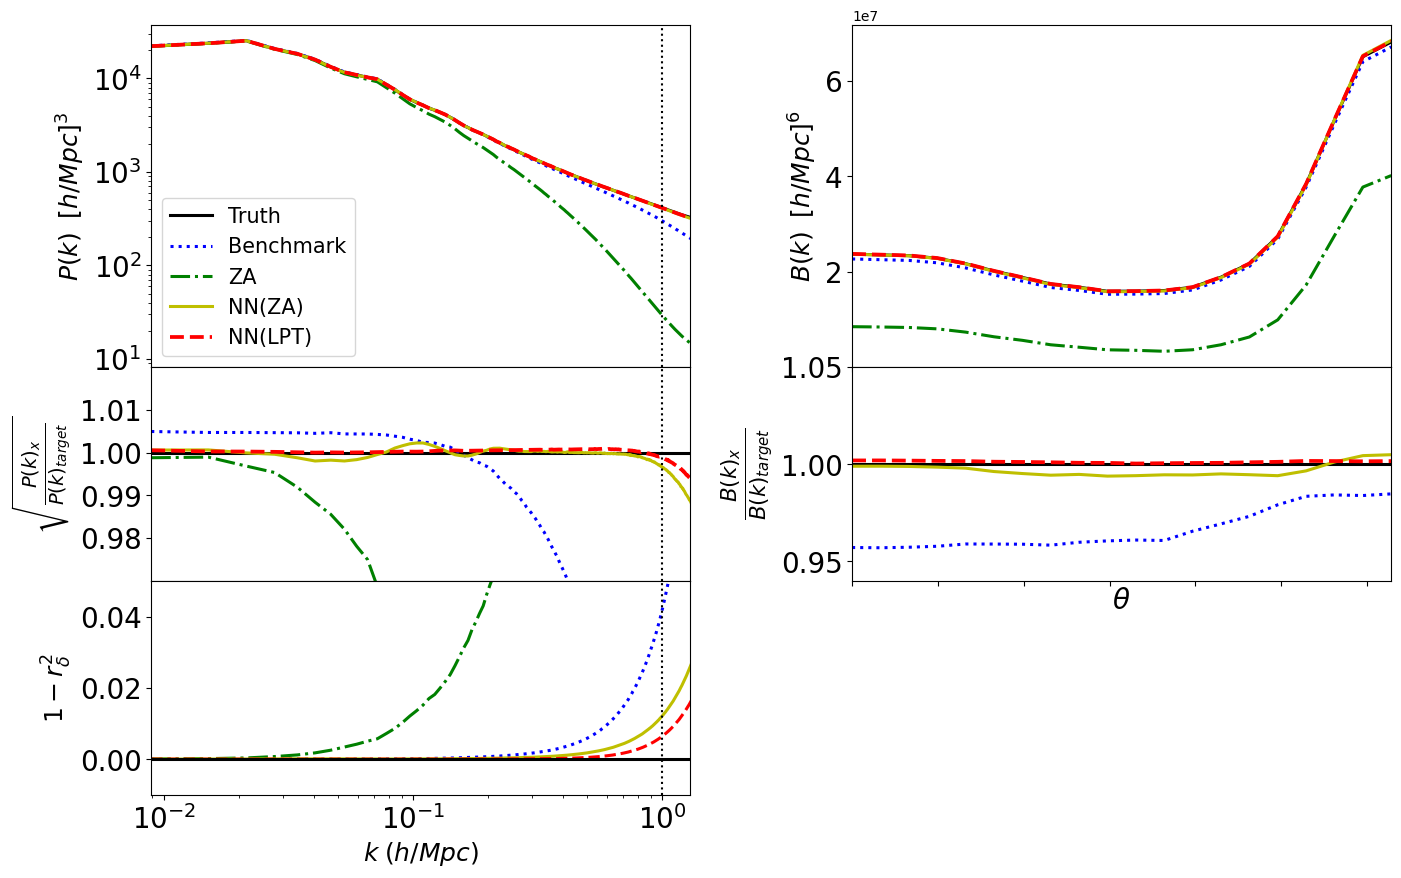

In [11]:
# Create two subplots and unpack the output array immediately

lw = 2.2
xlimdist = 1.3
ticklabelsize = 20
axeslabelsize = 18
legendsize=15
plt.style.use('default')
f, ax = plt.subplots(3, 2, figsize=(16,10), gridspec_kw={'height_ratios': [1.6, 1, 1]}, sharex='col')
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.001)

ax1,ax2,ax3,ax4,ax5,ax6 = ax[0,0], ax[1,0], ax[0,1], ax[1,1], ax[2,0], ax[2,1]
ax6.axis('off')

ax1.plot(avg_k , avg_pk_quij     , c='k', lw=lw, ls ='-' , label=r'Truth')
ax1.plot(avg_k , avg_pk_cola     , c='b', lw=lw, ls =':' , label=r'Benchmark')
ax1.plot(avg_k , avg_pk_za       , c='g', lw=lw, ls ='-.' , label='ZA')
ax1.plot(avg_k , avg_pk_za2quij  , c='y', lw=lw, ls ='-', label='NN(ZA)')
ax1.plot(avg_k , avg_pk_cola2quij, c='r', lw=lw+.5, ls ='--', label='NN(LPT)')
ax1.axvline(1.0, c='k', ls=':')
ax1.set_ylabel(r"$P(k)\;\;[h/Mpc]^3$", fontsize=axeslabelsize)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(avg_k[0], xlimdist)
ax1.tick_params(axis='y', which='major', labelsize=ticklabelsize)
#ax1.set_xticks()
#ax1.set_yticks()
ax1.legend(fontsize=legendsize)


ax2.plot(avg_k , np.sqrt(avg_pk_quij     /avg_pk_quij), c='k', lw=lw, ls ='-' , label=r'Truth')
ax2.plot(avg_k , np.sqrt(avg_pk_cola     /avg_pk_quij), c='b', lw=lw, ls =':' , label=r'Benchmark')
ax2.plot(avg_k , np.sqrt(avg_pk_za       /avg_pk_quij), c='g', lw=lw, ls ='-.' , label='ZA')
ax2.plot(avg_k , np.sqrt(avg_pk_za2quij  /avg_pk_quij), c='y', lw=lw, ls ='-', label='NN(ZA)')
ax2.plot(avg_k , np.sqrt(avg_pk_cola2quij/avg_pk_quij), c='r', lw=lw+.5, ls ='--', label='NN(LPT)')
ax2.axvline(1.0, c='k', ls=':')
ax2.set_xlabel(r"$k\;\;[h/Mpc]$", fontsize=axeslabelsize)
ax2.set_ylabel(r"$\sqrt{\frac{P(k)_x}{P(k)_{target}}}$", fontsize=axeslabelsize+2)
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.set_xlim(avg_k[0], xlimdist)
#ax2.set_ylim(0.9, 1.05)
ax2.set_ylim(0.97, 1.02)
ax2.tick_params(axis='both', which='major', labelsize=ticklabelsize)
ax2.set_yticks([0.98,0.99,1.0,1.01])
#ax1.set_xticks()
#ax1.set_yticks()
#ax2.legend(fontsize=18)

ax3.plot(theta , avg_bk_quij     , c='k', lw=lw, ls ='-' , label=r'Truth')
ax3.plot(theta , avg_bk_cola     , c='b', lw=lw, ls =':' , label=r'Benchmark')
ax3.plot(theta , avg_bk_za       , c='g', lw=lw, ls ='-.' , label='ZA')
ax3.plot(theta , avg_bk_za2quij  , c='y', lw=lw, ls ='-', label='NN(ZA)')
ax3.plot(theta , avg_bk_cola2quij, c='r', lw=lw+.5, ls ='--', label='NN(LPT)')
#ax3.axvline(1.0, c='k', ls=':')
ax3.set_ylabel(r"$B(k)\;\;[h/Mpc]^6$", fontsize=axeslabelsize)
#ax3.set_xscale('log')
#ax3.set_yscale('log')
#ax3.set_xlim(avg_k[0], xlimdist)
ax3.tick_params(axis='y', which='major', labelsize=ticklabelsize)
#ax3.legend(fontsize=legendsize)


ax4.plot(theta , avg_bk_quij     /avg_bk_quij, c='k', lw=lw, ls ='-' , label=r'Truth')
ax4.plot(theta , avg_bk_cola     /avg_bk_quij, c='b', lw=lw, ls =':' , label=r'Benchmark')
ax4.plot(theta , avg_bk_za       /avg_bk_quij, c='g', lw=lw, ls ='-.' , label='ZA')
ax4.plot(theta , avg_bk_za2quij  /avg_bk_quij, c='y', lw=lw, ls ='-', label='NN(ZA)')
ax4.plot(theta , avg_bk_cola2quij/avg_bk_quij, c='r', lw=lw+.5, ls ='--', label='NN(LPT)')
#ax4.axvline(1.0, c='k', ls=':')
ax4.set_xlabel(r"$\theta$", fontsize=axeslabelsize+2)
ax4.set_ylabel(r"$\frac{B(k)_x}{B(k)_{target}}$", fontsize=axeslabelsize+4)
#ax4.set_xscale('log')
#ax2.set_yscale('log')
#ax4.set_xlim(avg_k[0], xlimdist)
ax4.set_ylim(0.94, 1.05)
ax4.set_xlim(theta[0], theta[-1])
ax4.tick_params(axis='both', which='major', labelsize=ticklabelsize)
#ax1.set_xticks()
#ax1.set_yticks()
#ax2.legend(fontsize=18)

#f.tight_layout()

# lw = 2.2
# xlimdist = 1.3
# ticklabelsize = 20
# axeslabelsize = 20
# legendsize=17

#f, ax1 = plt.subplots(1, 1, figsize=(12,8))
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.1)

ax5.plot(avg_k , 1-avg_r_cola_x_quij**2      , c='b', lw=lw, ls =':' , label=r'Benchmark')
ax5.plot(avg_k , 1-avg_r_za_x_quij**2        , c='g', lw=lw, ls ='-.' , label='ZA')
ax5.plot(avg_k , 1-avg_r_za2quij_x_quij**2   , c='y', lw=lw, ls ='-', label='NN(ZA)')
ax5.plot(avg_k , 1-avg_r_cola2quij_x_quij**2 , c='r', lw=lw, ls ='--', label='NN(LPT)')
ax5.axvline(1.0, c='k', ls=':')
ax5.axhline(0.0, c='k', label='target', lw=lw)
ax5.set_xscale('log')
ax5.set_xlim(avg_k[0], xlimdist)
ax5.set_ylim(-0.01,0.05)
ax5.set_xlabel(r"$k\;(h/Mpc)$", fontsize=axeslabelsize)
ax5.set_ylabel(r"$1-r_{\delta}^2$", fontsize=axeslabelsize)
ax5.tick_params(axis='both', which='major', labelsize=ticklabelsize)
ax5.set_yticks([0.0,0.02,0.04])#0.99,1.0,1.01])
#ax5.legend(fontsize=legendsize)

#f.savefig(os.path.join(path_to_save,'test_r.png'))

f.savefig(os.path.join(path_to_save,'test_results.png'))

# $(1-r^2)$ 

In [ ]:
lw = 2.5
xlimdist = 1.3
ticklabelsize = 20
axeslabelsize = 20
legendsize=17

f, ax1 = plt.subplots(1, 1, figsize=(12,8))
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.1)

ax1.plot(avg_k , 1-avg_r_cola_x_quij**2      , c='b', lw=lw, ls =':' , label=r'Benchmark')
ax1.plot(avg_k , 1-avg_r_za_x_quij**2        , c='g', lw=lw, ls ='-.' , label='ZA')
ax1.plot(avg_k , 1-avg_r_za2quij_x_quij**2   , c='y', lw=lw, ls ='-', label='NN(ZA)')
ax1.plot(avg_k , 1-avg_r_cola2quij_x_quij**2 , c='r', lw=lw, ls ='--', label='NN(LPT)')
ax1.axvline(1.0, c='k', ls=':', lw=lw)
ax1.axhline(0.0, c='k', label='target', lw=lw)
ax1.set_xscale('log')
ax1.set_xlim(avg_k[0], xlimdist)
ax1.set_ylim(-0.01,0.05)
ax1.set_xlabel(r"$k\;(h/Mpc)$", fontsize=axeslabelsize)
ax1.set_ylabel(r"$1-r_{\delta}^2$", fontsize=axeslabelsize)
ax1.tick_params(axis='both', which='major', labelsize=ticklabelsize)
ax1.legend(fontsize=legendsize)

f.savefig(os.path.join(path_to_save,'test_r.png'))